## Проект 8. Прогнозирование стоимости автомобиля с пробегом
### Грачева Татьяна, Еременко Виктория¶

### Задача: создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам

Если наша модель работает хорошо, то мы сможем быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.

#### В данной работе мы сделаем следующее:

*Обработаем и отнормируем признаки
*Построим первые модели на основе деревьев решений
*Сделаем модель на основе нейронных сетей и сравним результаты
*Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
*Добавим в multi-input сеть обработку изображений
*Осуществим ансамблирование моделей на основе дерерьев решений и нейронной сети (усреднение их предсказаний)

In [2]:
!pip install transformers

In [3]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 672.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 19.2 MB/s eta 0:00:00


In [4]:
# Загружаем обертку под keras для использования продвинутых библиотек аугментации
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-t9pj50iv
  Running command git clone --filter=blob:none --quiet https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-t9pj50iv
  Resolved https://github.com/mjkvaak/ImageDataAugmentor to commit 9f16ebd3e667cc16cde49f1ec1e5211e7962cd5c
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 16.8 MB/s eta 0:00:00
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29644 sha256=d93d078e28bff0d4b10a6d725b41e30ff797180618dd222074a398fbf34695fe
  Stored in directory: /tmp/pip-ephem-wheel-cache-s5b4k4pl/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60


In [5]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from pandas_profiling import ProfileReport
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')

from optuna import *

# библиотеки для очистки текста
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import pymorphy2


from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor


from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

#image augmentation
import albumentations as A
from ImageDataAugmentor.image_data_augmentor import *

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanAbsolutePercentageError

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED'] = '42'

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
Numpy        : 1.21.6
Tensorflow   : 2.6.4


In [7]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [8]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Setup

In [9]:
DIR_TRAIN  = '../input/sf-dst-car-price-prediction-part2/'
VAL_SIZE   = 0.15   
N_FOLDS    = 5

# Data

Каггл

In [10]:
!ls ../input/

sf-dst-car-price-prediction-part2


In [11]:
train = pd.read_csv(DIR_TRAIN+'train.csv') # подготовленный датасет для обучения модели
test = pd.read_csv(DIR_TRAIN+'test.csv')
sample_submission = pd.read_csv(DIR_TRAIN+'sample_submission.csv')

Локально

In [12]:
#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')
#sample_submission = pd.read_csv('sample_submission.csv')

In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


## Data Preprocessing

Функции предобработки данных

In [14]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

# обработка данных
def get_correct_engineDisplacement(x):
    ''' Функция приводит объем двигателя к числовому формату'''
    
    if x == 'undefined LTR':  # у электрокаров объем равен 0 
        return 0
    
    x = float(x.split(' LTR')[0])
    
    return x

def num_of_months(row):
    ''' Функция считает время владения машиной в месяцах'''
    
    if pd.notnull(row):
        list_ownership = row.split()
        if len(list_ownership) == 2:
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])
        return int(list_ownership[0])*12 + int(list_ownership[3])


def fill_na_ownership(row):
    ''' Функция для заполнения пропущенных значений (время владения машиной)'''
    
    row['Владение'] = ownership_dict.get(row['Владельцы'])
    
    return row


# функции обработки текста

def remove_punctuations(data):
    ''' Функция удаляет знаки препинания'''
    
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r' ',data)
    return data


def remove_emoji(data):
    ''' Функция удаляет эмоджи'''    
    
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    return data


def remove_numbers(data):
    ''' Функция удаляет цифры'''
    
    num_tag=re.compile(r'[\d]')
    data=num_tag.sub(r'',data)
    return data

def remove_latin_literals(data):
    ''' Функция удаляет латиницу'''
    
    lit_tag=re.compile(r'[abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ]')
    data=lit_tag.sub(r'',data)
    return data

# округление предсказаний
def round_to(x, a):
    ''' Функция округления до заданной величины'''
    
    return round(x / a) * a

## Анализ объединенного датасета

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              8353 non-null   object 
 1   brand                 8353 non-null   object 
 2   color                 8353 non-null   object 
 3   description           8353 non-null   object 
 4   engineDisplacement    8353 non-null   object 
 5   enginePower           8353 non-null   object 
 6   fuelType              8353 non-null   object 
 7   mileage               8353 non-null   int64  
 8   modelDate             8353 non-null   int64  
 9   model_info            8353 non-null   object 
 10  name                  8353 non-null   object 
 11  numberOfDoors         8353 non-null   int64  
 12  productionDate        8353 non-null   int64  
 13  sell_id               8353 non-null   int64  
 14  vehicleConfiguration  8353 non-null   object 
 15  vehicleTransmission  

In [16]:
data.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0 LTR,136 N12,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0 LTR,190 N12,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1 владелец,NaN,Оригинал,полный,Левый,0,0.0


In [17]:
# В этой колонке дублируется информация из других колонок, так что удаляем
data.drop('vehicleConfiguration', axis = 1, inplace=True)

In [18]:
# Быстрый EDA 
#profile = ProfileReport(data, title='Dataset Pandas Profiling Report', explorative = True)
#profile

## Посмотрим на переменные нашего датасета


#### bodyType - тип кузова
17 разных значения из-за лишней информации в признаке (кол-во дверей). Пропусков нет. 

In [19]:
# В признаке "тип кузова" уберем лишнюю информацию
data.bodyType = data.bodyType.apply(lambda x: x.split(' ')[0])

data.bodyType.nunique()

13

#### engineDisplacement - объем двигателя в литрах

In [20]:
# значение undefined только у электрокаров => у них объем двигателя равен нулю
data[data.engineDisplacement == 'undefined LTR'].fuelType.value_counts()

электро    6
Name: fuelType, dtype: int64

In [21]:
data.engineDisplacement = data.engineDisplacement.apply(get_correct_engineDisplacement)

#### enginePower - мощность двигателя

In [22]:
# приведем признак в тесте в типу данных int64 и уберем ' N12'
data.enginePower = data.enginePower.apply(lambda x: int(x.split(' N12')[0]))

#### Владельцы
В датасете представлены только подержаные машины - от одного и более предыдущих владельцев

In [23]:
# единственный пропуск заполним самым часто встречающимся значением
data['Владельцы'].fillna(data['Владельцы'].value_counts().index[0], inplace=True)
# оставим в этой колонке только число
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(x.split()[0]))

#### Владение - количество лет и месяцев владения машиной у последнего владельца

In [24]:
#Переведем признак в числовой формат - количество месяцев
data['Владение'] = data['Владение'].apply(num_of_months)
#По-прежнему много пропусков
data['Владение'].isna().sum()

5418

In [25]:
# Заполним отсутствующие значения медианой (группируем по количеству владельцев) 
ownership = data[data.Владение != 'NaN'].groupby('Владельцы').Владение.median()
ownership_dict = ownership.to_dict()
data[data.Владение.isna()]= data[data.Владение.isna()].apply(fill_na_ownership, axis=1)

In [26]:
# достанем признак 'xDrive' из колонки name
data['xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
# в признаке name оставляем только комплектацию автомобиля
data['name'] = data['name'].str.split().apply(lambda x: x[0])

In [27]:
# датасет был собран в 2020 году, так что отсчет ведем с этого момента
data['car_age'] = 2020 - data.productionDate
# колонку удалим
data.drop('productionDate', axis = 1, inplace=True)

### Анализ категориальных переменных

In [28]:
bin_cols = ['ПТС', 'Руль','xDrive']
cat_cols = ['bodyType', 'brand','color','fuelType', 'model_info', 'name','numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод']
num_cols = ['modelDate','engineDisplacement', 'enginePower','mileage', 'car_age', 'Владение']

### Дополнительная обработка категориальных переменных

In [29]:
# Перекодируем бинарные переменные с текстовыми значениями
le = LabelEncoder()
for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    print(dict(enumerate(le.classes_)))

    # Создадим фиктивные переменные на основе категориальных колонок
ohe = OneHotEncoder(sparse = False, dtype='uint8')
cat_cols_encoded = ohe.fit_transform(data[cat_cols].values)
cat_cols_encoded_features = ohe.get_feature_names(cat_cols)
data[cat_cols_encoded_features] = pd.DataFrame(cat_cols_encoded, columns=cat_cols_encoded_features)


dummy_cols= list(cat_cols_encoded_features) + bin_cols

{0: 'Дубликат', 1: 'Оригинал'}
{0: 'Левый', 1: 'Правый'}
{0: 0, 1: 1}


### Числовые переменные

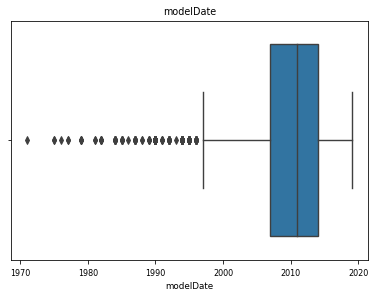

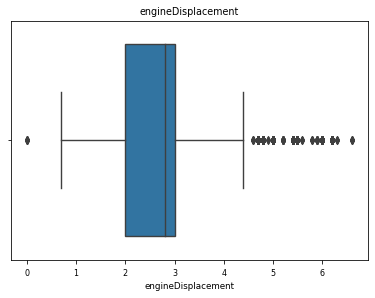

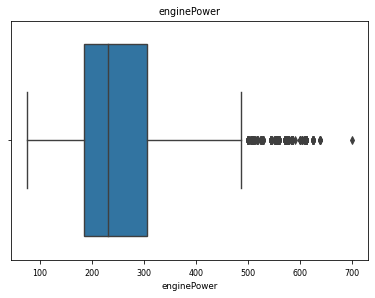

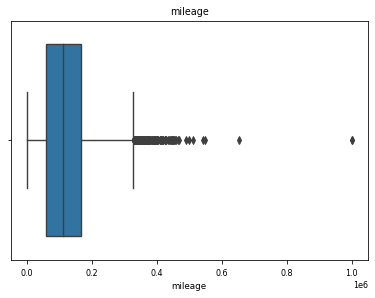

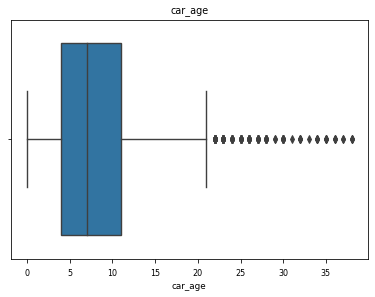

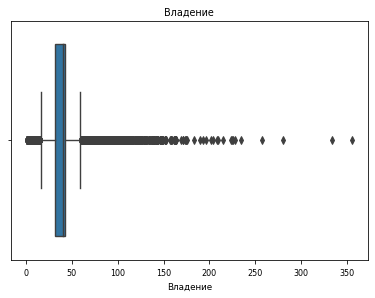

In [30]:
for col in num_cols:
    plt.figure()
    sns.boxplot(data[col])
    plt.title(col)
    plt.show()


Практически во всех числовых переменных есть выбросы, распределения имеют выраженные правые "хвосты".

## Генерация признаков

In [31]:
# Добавим новый признак - длина описания в символах (мб лучше сделать длину в словах?)
data['description_len'] = data['description'].apply(lambda x: len(x))
num_cols.append('description_len')

<AxesSubplot:xlabel='description_len'>

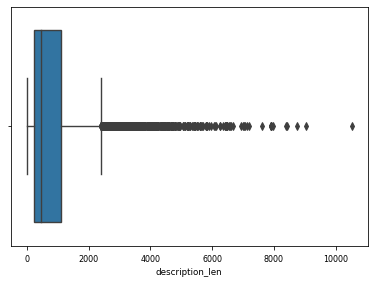

In [32]:
sns.boxplot(data['description_len'])

In [33]:
# признак - километраж за год. 
# Прибавляем 1 к возрасту машины, чтобы километраж был посчитан для машин, которые были произведены в год сбора данных
data['miles_per_year'] = data['mileage'] // (data['car_age'] + 1)
data['miles_per_year'].astype(int)
num_cols.append('miles_per_year')

<AxesSubplot:xlabel='miles_per_year'>

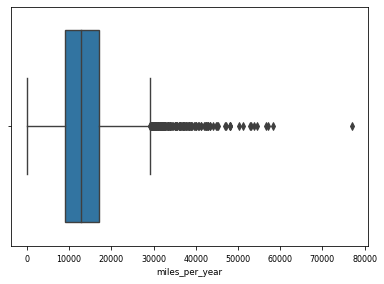

In [34]:
sns.boxplot(data['miles_per_year'])

In [35]:
# введем новый признак "tax" (расчет годового налога):
data['tax'] = data.enginePower.apply(lambda x: x*12 if x <= 100
                                     else x*25 if x > 100 and x <= 125
                                     else x*35 if x > 125 and x <= 150
                                     else x*45 if x > 150 and x <= 175
                                     else x*55 if x > 175 and x <= 200
                                     else x*65 if x > 200 and x <= 225
                                     else x*75 if x > 225 and x <= 250
                                     else x*150)
num_cols.append('tax')

<AxesSubplot:xlabel='tax'>

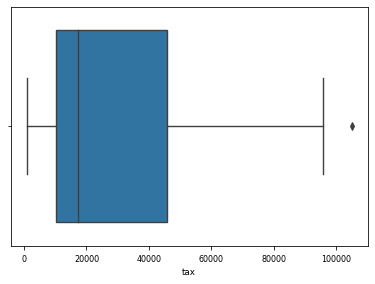

In [36]:
sns.boxplot(data['tax'])

## Отбор признаков

In [37]:
target = 'price'
train_index = data[data['sample'] == 1].index
test_index = data[data['sample'] == 0].index

### Корреляционный анализ

(10.5, -0.5)

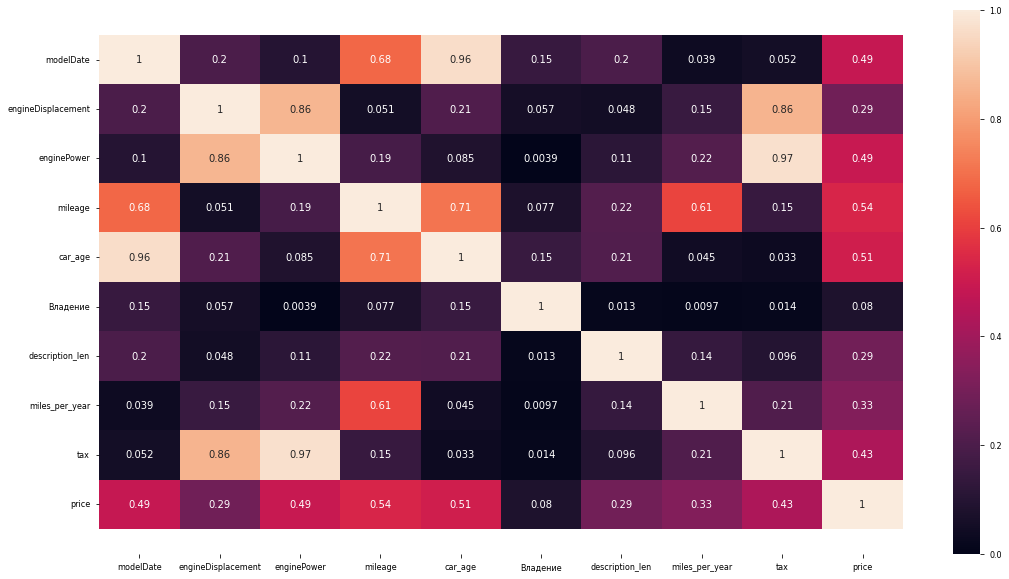

In [38]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data.loc[train_index][num_cols+[target]].corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)


Несмотря на высокие корреляции, признаки удалять не стали, тк это увеличивало ошибку.

In [39]:
# числовые колонки логарифмируем,чтобы избавиться от правых хвостов распределений
for col in num_cols:
    data[col] = np.log(data[col] + 1)

In [40]:
# логарифмируем цену
data.price = np.log(data.price)

### Подготовка данных для машинного обучения

In [41]:
train_proc = data.loc[train_index]
test_proc = data.loc[test_index]

In [42]:
train_proc.shape, test_proc.shape

((6682, 434), (1671, 434))

In [43]:
X = train_proc[dummy_cols+ num_cols]
X_sub = test_proc[dummy_cols+num_cols]

y = train_proc['price'].values

In [44]:
# стандартизация числовых признаков

scaler = RobustScaler()
X[num_cols]  = scaler.fit_transform(X[num_cols])
X_sub[num_cols]  = scaler.transform(X_sub[num_cols])

## Модели машинного обучения

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

### Ансамбли на основе деревьев решений

In [46]:
extra_tree = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
extra_tree.fit(X_train, y_train)
predict_extra_tree = extra_tree.predict(X_test)

# оцениваем точность
print(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")

# MAPE: 11.36%

MAPE: 11.36%


### Бустинг. Catboost

In [47]:
catboost = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = 0.02,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         cat_features=dummy_cols,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0419778	test: 0.0420384	best: 0.0420384 (0)	total: 87.2ms	remaining: 2m 54s
100:	learn: 0.0126645	test: 0.0126863	best: 0.0126863 (100)	total: 2.99s	remaining: 56.2s
200:	learn: 0.0092022	test: 0.0095477	best: 0.0095477 (200)	total: 5.92s	remaining: 53s
300:	learn: 0.0083151	test: 0.0089297	best: 0.0089297 (300)	total: 9.77s	remaining: 55.1s
400:	learn: 0.0077667	test: 0.0086290	best: 0.0086290 (400)	total: 12.7s	remaining: 50.6s
500:	learn: 0.0072860	test: 0.0083774	best: 0.0083774 (500)	total: 15.6s	remaining: 46.8s
600:	learn: 0.0068755	test: 0.0081966	best: 0.0081966 (600)	total: 18.9s	remaining: 44s
700:	learn: 0.0065556	test: 0.0080910	best: 0.0080910 (700)	total: 21.9s	remaining: 40.6s
800:	learn: 0.0062542	test: 0.0080052	best: 0.0080050 (797)	total: 24.9s	remaining: 37.2s
900:	learn: 0.0059777	test: 0.0079357	best: 0.0079357 (900)	total: 27.9s	remaining: 34s
1000:	learn: 0.0057617	test: 0.0078888	best: 0.0078880 (999)	total: 31.3s	remaining: 31.2s
1100:	learn: 0.00

In [48]:
 #оцениваем точность предсказания
predict_catboost = catboost.predict(X_test)

print(f"MAPE: {(mape_log(y_test, predict_catboost))*100:0.2f}%")

# MAPE: 11.13 %

MAPE: 11.13%


### Стэкинг

In [50]:
# только catboost и extra_trees

#estimators = [('extra_trees', extra_tree),
              #('catboost', catboost)]
         

#stack = StackingRegressor(estimators=estimators,
                          #n_jobs=-1,
                          #cv=5)

#stack.fit(X_train, y_train)

# Проверка  

#predict_stack = stack.predict(X_test)
#print(f"MAPE: {(mape_log(y_test, predict_stack))*100:0.2f}%")

# MAPE: 11.03%


### Простое усреднение с коэффициентами (голосование)
Оказалось более эффективным, чем стэкинг, поэтому в дальнейшем используем его

In [51]:
avg_predict_ml = 0.5*predict_extra_tree + 0.5*predict_catboost
print(f"MAPE: {(mape_log(y_test, avg_predict_ml))*100:0.2f}%")

#MAPE 10.81%

MAPE: 10.81%


Самая результативная модель - усреднение результатов Catboost Extra и Trees Regressor.
Сохраняем сабмит. 

In [52]:
# предикт без округления
predict_extra_tree_sub = np.exp(extra_tree.predict(X_sub))
predict_catboost_sub = np.exp(catboost.predict(X_sub))

predict_avg_ml_submission =  0.5*predict_extra_tree_sub + 0.5*predict_catboost_sub
sample_submission['price'] = predict_avg_ml_submission

# округлим предикт, так как очень редко встречаются цены имеющие остаток при делении на 1000

sample_submission['price'] = round_to(sample_submission['price'], 1000)
sample_submission.to_csv('submission_avg_round.csv', index=False)
sample_submission.head()

,sell_id,price
0,1099427284,691000.0
1,1096405886,2536000.0
2,1100195294,646000.0
3,1099827282,479000.0
4,1100076198,2659000.0


## Model 3: Tabular NN

In [53]:
# обратили внимание, что нейросеть лучше дает результат, если цена не логарифмирована.
# соответственно, вернем цену к обычному формату

In [54]:
K.clear_session()
tabular_nn = Sequential()
tabular_nn.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid")) 
tabular_nn.add(L.Dropout(0.5))
tabular_nn.add(L.Dense(256, activation="relu"))
tabular_nn.add(L.Dense(256, activation="relu")) #добавили допонительный полносвязный слой
tabular_nn.add(L.Dropout(0.5))
tabular_nn.add(L.Dense(1, activation="linear"))

2022-06-29 23:42:14.520479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 23:42:14.522270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 23:42:14.523479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 23:42:14.524669: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [55]:
tabular_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               215552    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 412,929
Trainable params: 412,929
Non-trainable params: 0
__________________________________________________

In [56]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.005)
tabular_nn.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [57]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE',
                    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_MAPE',
                              #factor=0.25,
                              #patience=50,
                              #min_lr = 0,
                              #verbose=1,
                              #mode='auto')

callbacks_list = [checkpoint, earlystop]#, reduce_lr]

In [58]:
history = tabular_nn.fit(X_train, np.exp(y_train),
                    batch_size=512,
                    epochs=1000,  
                    validation_data=(X_test, np.exp(y_test)),
                    callbacks=callbacks_list,
                    verbose=1,
                    )

2022-06-29 23:42:20.710835: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
12/12 [==============================] - 2s 26ms/step - loss: 99.9835 - MAPE: 99.9835 - val_loss: 99.8889 - val_MAPE: 99.8889
Epoch 2/1000
12/12 [==============================] - 0s 6ms/step - loss: 99.5295 - MAPE: 99.5295 - val_loss: 98.4757 - val_MAPE: 98.4757
Epoch 3/1000
12/12 [==============================] - 0s 5ms/step - loss: 96.4679 - MAPE: 96.4679 - val_loss: 91.7959 - val_MAPE: 91.7959
Epoch 4/1000
12/12 [==============================] - 0s 5ms/step - loss: 85.4911 - MAPE: 85.4911 - val_loss: 72.6620 - val_MAPE: 72.6620
Epoch 5/1000
12/12 [==============================] - 0s 5ms/step - loss: 62.0126 - MAPE: 62.0126 - val_loss: 51.1581 - val_MAPE: 51.1581
Epoch 6/1000
12/12 [==============================] - 0s 5ms/step - loss: 50.9337 - MAPE: 50.9337 - val_loss: 52.2549 - val_MAPE: 52.2549
Epoch 7/1000
12/12 [==============================] - 0s 5ms/step - loss: 51.2103 - MAPE: 51.2103 - val_loss: 49.9263 - val_MAPE: 49.9263
Epoch 8/1000
12/12 [=============

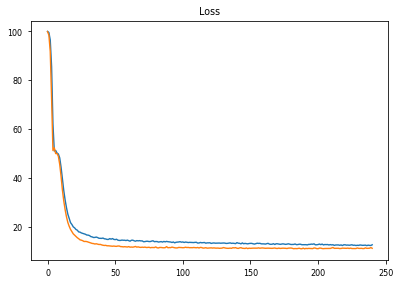

In [59]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [60]:
tabular_nn.load_weights('../working/best_model.hdf5')
tabular_nn.save('../working/tabular_nn.hdf5')

In [61]:
predict_tabular_nn = tabular_nn.predict(X_test)
print(f"MAPE: {(mape(np.exp(y_test), predict_tabular_nn[:,0]))*100:0.2f}%")

# MAPE: 10.89%

MAPE: 10.89%


In [62]:
# усредненные предикты ML  и простой нейросети
new_pred = (np.exp(avg_predict_ml) + predict_tabular_nn[:,0])/2
print(f"TEST mape: {(mape(np.exp(y_test), new_pred))*100:0.2f}%")

#TEST mape: 10.27%

TEST mape: 10.27%


In [63]:
predict_sub_tabular_nn = tabular_nn.predict(X_sub)

In [64]:
sample_submission['price'] = (predict_avg_ml_submission + predict_sub_tabular_nn[:,0])/2
sample_submission['price'] = round_to(sample_submission['price'], 1000)
sample_submission.to_csv('avg_ml_tabular_submission_round.csv', index=False)
sample_submission.head()

# Kaggle 10.99763

,sell_id,price
0,1099427284,689000.0
1,1096405886,2493000.0
2,1100195294,638000.0
3,1099827282,488000.0
4,1100076198,2683000.0


### Проброс признака 
Возраст машины - car_age

In [65]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))


In [66]:
len(X.car_age.unique().tolist())+1

39

In [67]:
# FEATURE Input
# Iput
car_age = L.Input(shape=[1], name="car_age")
# Embeddings layers
emb_car_age = L.Embedding(len(X.car_age.unique().tolist())+1, 39)(car_age)
f_car_age = L.Flatten()(emb_car_age)

In [68]:
combinedInput = L.concatenate([model_mlp.output, f_car_age,])
# being our regression head
layer = L.Dense(256, activation="relu")(combinedInput)
layer = L.Dropout(0.5)(layer)
head = L.Dense(1, activation="linear")(layer)

model = Model(inputs=[model_mlp.input, car_age], outputs=head)

In [69]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [70]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE',
                    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_MAPE',
                              #factor=0.25,
                              #patience=50,
                              #min_lr = 0,
                              #verbose=1,
                              #mode='auto')

callbacks_list = [checkpoint, earlystop]#, reduce_lr]

In [71]:
history = model.fit([X_train, X_train.car_age.values], np.exp(y_train),
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.car_age.values], np.exp(y_test)),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 1s 24ms/step - loss: 99.9830 - MAPE: 99.9830 - val_loss: 99.8876 - val_MAPE: 99.8876
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 99.5360 - MAPE: 99.5360 - val_loss: 98.5084 - val_MAPE: 98.5084
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 96.5853 - MAPE: 96.5853 - val_loss: 92.0991 - val_MAPE: 92.0991
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 86.0635 - MAPE: 86.0635 - val_loss: 73.7860 - val_MAPE: 73.7860
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 63.1366 - MAPE: 63.1366 - val_loss: 51.6263 - val_MAPE: 51.6263
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 51.0360 - MAPE: 51.0360 - val_loss: 51.9719 - val_MAPE: 51.9719
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 51.3561 - MAPE: 51.3561 - val_loss: 49.9456 - val_MAPE: 49.9456
Epoch 8/500
12/12 [=====================

In [72]:
# Проброс признака не улучшил ситуацию
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.car_age.values])
print(f"TEST mape: {(mape(np.exp(y_test), test_predict_nn_bonus[:,0]))*100:0.2f}%")
#TEST mape: 10.99%

TEST mape: 10.99%


## NLP сеть

Попробуем извлечь дополнительную информацию из колонки с описанием автомобиля со стороны продавца.

In [73]:
data['description_len_words'] = data['description'].apply(lambda x: len(x.split(' ')))

<AxesSubplot:xlabel='description_len_words'>

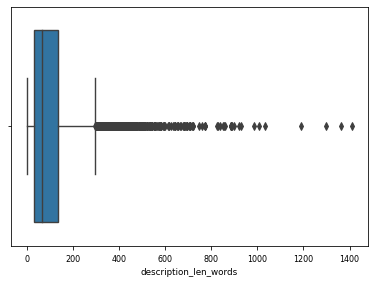

In [74]:
sns.boxplot(data['description_len_words'])

Мы видим, что 75% отзывов укладываются примерно в 300 слов

In [75]:
for i in range(3):
    print(f'Описание {i}\n')
    print(data['description'][i])

Описание 0

Всем привет!

Продам эксклюзивный проект 124 универсал 300TE-24 SportLine

Модель 124.091 300 TE-24
Двигатель 104.980
Трансмиссия 722.359
Цвет кузова 040 (черный)
Отделка салона 271 (Кожа черная / "антрацит")

Опции:
211 Автоматическая блокировка дифференциала (ASD)
240 Индикатор внешней температуры
244 Спортивные сиденья спереди
281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП
291 Подушка безопасности для водителя и переднего пассажира
300 Дополнительный бардачок в вещевом отсеке спереди
412 Люк с электроприводом и устройством подъёма
420 Автоматическая коробка передач, напольное исполнение
440 Темпомат (круиз-контроль)
538 Автоматическая антенна
541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)
570 Складной подлокотник спереди
586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей
598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)
650 Спортивная подвеска

####Что видим здесь:
* большие буквы - нужно привести все к нижнему регистру
* поскольку модель русскоязычная, текст на латинице не распознает - нужно по возможности убрать англоязычный текст
* запятые, точки, тире, восклицательные знаки, эмоджи - скорее всего, не несут полезной информации
* цифры также удалим

In [76]:
data['description'] = data['description'].apply(lambda x: x.lower())

In [77]:
%%time

data['description']=data['description'].apply(lambda x: remove_punctuations(x))
data['description']=data['description'].apply(lambda x: remove_emoji(x))
data['description']=data['description'].apply(lambda x: remove_numbers(x))
data['description']=data['description'].apply(lambda x: remove_latin_literals(x))


CPU times: user 1.1 s, sys: 5.54 ms, total: 1.11 s
Wall time: 1.1 s


In [78]:
# удаляем ненужные (неинформативные) слова
stop = stopwords.words('russian')
add_stop = ['км','мм', 'рублей'] + list('абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ')
new_stop = stop + add_stop
print(new_stop)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [79]:
data['description']=data['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (new_stop)]))
data['description'].head()

0    всем привет продам эксклюзивный проект универс...
1    продаю любимейшую тачилу обвес тюнинг езжу дол...
2    машина продаётся первый перебран двигатель зам...
3    автомобиль отличном состоянии весь родной крас...
4    немка бесключивым доступом камерой заднего вид...
Name: description, dtype: object

### Лемматизация текста

In [81]:
# попробуем сократить количество грамматических форм одних и тех же слов

%%time

morph = pymorphy2.MorphAnalyzer()


def filter_str(str):
    split_str = str.split()
    filtered_str = ' '.join(
        (map(lambda s: morph.parse(s)[0].normal_form, split_str)))
    return filtered_str


data['description'] = data['description'].apply(filter_str)
data['description']

CPU times: user 2min 19s, sys: 190 ms, total: 2min 19s
Wall time: 2min 19s


0       весь привет продать эксклюзивный проект универ...
1       продавать любимый тачил обвес тюнинг ездить до...
2       машина продаваться первый перебрать двигатель ...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    продаваться любимый автомобиль год эксплуатаци...
8349    купить официальный дилер третий владелец владе...
8350    торг место работать сборка немецкий резина лет...
8351    автомобиль отличный состояние авто семья обслу...
8352    удлинённый заводский база вообще правильно зав...
Name: description, Length: 8353, dtype: object

### Токенизация текста

In [83]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [84]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [85]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 945 ms, sys: 3.85 ms, total: 949 ms
Wall time: 949 ms


In [86]:
tokenize.word_index

{'автомобиль': 1,
 'система': 2,
 'пробег': 3,
 'задний': 4,
 'салон': 5,
 'сидение': 6,
 'год': 7,
 'состояние': 8,
 'передний': 9,
 'машина': 10,
 'диск': 11,
 'комплект': 12,
 'дилер': 13,
 'новый': 14,
 'официальный': 15,
 'ваш': 16,
 'кредит': 17,
 'фара': 18,
 'авто': 19,
 'гарантия': 20,
 'пакет': 21,
 'руль': 22,
 'колесо': 23,
 'безопасность': 24,
 'комплектация': 25,
 'обмен': 26,
 'птс': 27,
 'контроль': 28,
 'зеркало': 29,
 'проверка': 30,
 'покупка': 31,
 'продажа': 32,
 'водитель': 33,
 'полный': 34,
 'шина': 35,
 'датчик': 36,
 'отличный': 37,
 'пассажир': 38,
 'двигатель': 39,
 'резина': 40,
 'условие': 41,
 'владелец': 42,
 'ключ': 43,
 'кузов': 44,
 'подушка': 45,
 'подогрев': 46,
 'обогрев': 47,
 'технический': 48,
 'любой': 49,
 'обслуживание': 50,
 'хороший': 51,
 'юридический': 52,
 'оригинал': 53,
 'стекло': 54,
 'торг': 55,
 'масло': 56,
 'дверь': 57,
 'замена': 58,
 'чёрный': 59,
 'пройти': 60,
 'рулевой': 61,
 'электропривод': 62,
 'оригинальный': 63,
 'наш': 

In [87]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 941 ms, sys: 1.86 ms, total: 943 ms
Wall time: 942 ms


In [88]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобиль проверить пункт автокредит специальный ставка ауди центр север официальный дилер входящий группа компания рольф являться один крупный дилер европа предлагать ряд услуга покупка продажа автомобиль пробег протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди дилер россия предоставлять клиент самый большой выбор автомобиль пробег другой марка каждый автомобиль проходить тщательный диагностик подготовка гарантировать находиться отличный состояние убедиться правильный выбор возможность пройти тест драйв ознакомительный поездка интересовать автомобиль смочь ознакомиться автомобиль выходить дом наш менеджер провести презентация видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подобрать хороший условие кредитование проверить автомобиль пробег гарантия год ждать сайт мобильный приложение рольф
[   0    0    0    0    0    0    

### RNN NLP

In [89]:
# рекуррентная нейросеть для анализа текста
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [90]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))

### Multiple Inputs NN
Объединяем модель для обработки речи и простую полносвязную нейросеть

In [91]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
layer = L.Dense(256, activation="relu")(combinedInput)
layer = L.Dropout(0.5)(layer)
head = L.Dense(1, activation="linear")(layer)


model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [92]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [93]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE',
                    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [94]:
history = model.fit([text_train_sequences, X_train], np.exp(y_train),
                    batch_size=256,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], np.exp(y_test)),
                    callbacks=callbacks_list
                   )

Epoch 1/500


2022-06-29 23:45:44.524086: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


23/23 [==============================] - 8s 188ms/step - loss: 99.7702 - MAPE: 99.7702 - val_loss: 98.5582 - val_MAPE: 98.5582
Epoch 2/500
23/23 [==============================] - 4s 161ms/step - loss: 91.6470 - MAPE: 91.6470 - val_loss: 74.5843 - val_MAPE: 74.5843
Epoch 3/500
23/23 [==============================] - 4s 162ms/step - loss: 57.3245 - MAPE: 57.3245 - val_loss: 51.9204 - val_MAPE: 51.9204
Epoch 4/500
23/23 [==============================] - 4s 161ms/step - loss: 50.3864 - MAPE: 50.3864 - val_loss: 49.8415 - val_MAPE: 49.8415
Epoch 5/500
23/23 [==============================] - 4s 161ms/step - loss: 49.5105 - MAPE: 49.5105 - val_loss: 47.4467 - val_MAPE: 47.4467
Epoch 6/500
23/23 [==============================] - 4s 159ms/step - loss: 44.1270 - MAPE: 44.1270 - val_loss: 37.6324 - val_MAPE: 37.6324
Epoch 7/500
23/23 [==============================] - 4s 160ms/step - loss: 34.6936 - MAPE: 34.6936 - val_loss: 29.0817 - val_MAPE: 29.0817
Epoch 8/500
23/23 [====================

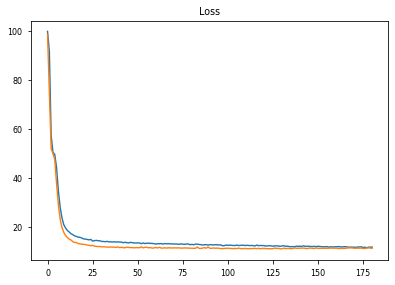

In [95]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [96]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [97]:
# результаты на валидации чуть хуже, чем у обычной полносвязной нейросети
predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(np.exp(y_test), predict_nn2[:,0]))*100:0.2f}%")

#TEST mape: 10.93%

TEST mape: 10.93%


In [98]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:, 0]
sample_submission['price'] = round_to(sample_submission['price'], 1000)
sample_submission.to_csv('nn2_submission_round.csv', index=False)

## CNN сеть
Используем дополнительные данные - фото выставленных на продажу автомобилей

### Загрузка и обработка изображений

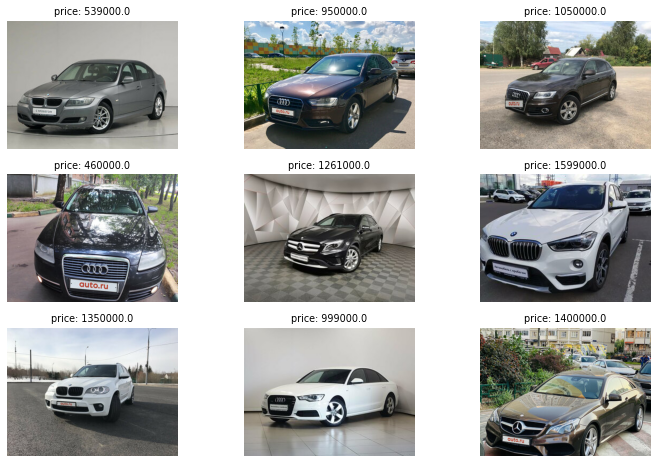

In [99]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize=(12, 8))

random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DIR_TRAIN + "/img/img/" + str(path) + ".jpg")
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [100]:
import cv2

size = (320, 240)  

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DIR_TRAIN + "/img/img/" + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)


images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


In [101]:
# добавляем в данные шум
AUGMENTATIONS = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.1),
    A.ShiftScaleRotate(shift_limit=0.05, 
                       scale_limit=0.02, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=10, 
                       p=.05),
    A.HorizontalFlip(p=0.5)])

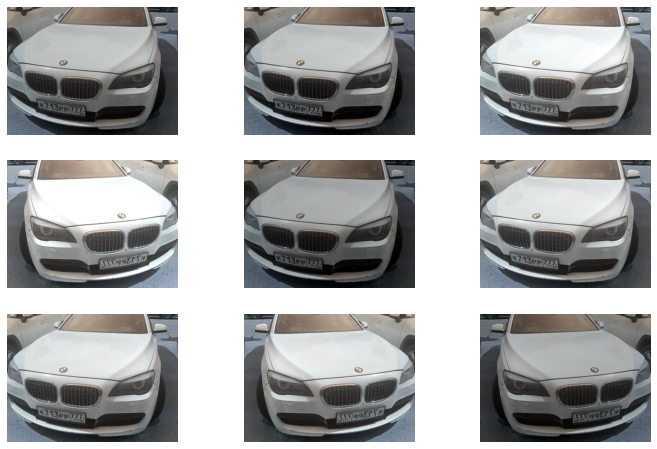

In [102]:
# пример
plt.figure(figsize=(12, 8))
for i in range(9):
    img = AUGMENTATIONS(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [103]:
def make_augmentations(images):
    print('применение аугментаций', end='')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end='')
        augment_dict = AUGMENTATIONS(image=images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [104]:
# функции для использования с конструктором датасетов

def process_image(image):
    return AUGMENTATIONS(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], np.exp(y_train)
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], np.exp(y_test)
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

2022-06-29 23:58:28.335155: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2022-06-29 23:58:29.844382: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2022-06-29 23:58:32.357019: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2022-06-29 23:58:33.431970: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-06-29 23:58:33.735350: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


In [105]:
# используем предобученную модель сверточной нейросети для классификации изображений
efficientnet_model = EfficientNetB3(weights='imagenet', 
                            include_top=False, 
                            input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)


43950080/43941136 [==============================] - 0s 0us/step


In [106]:
# размораживаем веса базовой модели
efficientnet_model.trainable = True

## Multi-input сеть

In [107]:
# рекуррентная нейросеть
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

In [108]:
# полносвязная нейросеть
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))

In [109]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, model_mlp.output, model_nlp.output])
# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)
model = Model(inputs=[efficientnet_model.input, model_mlp.input, model_nlp.input], outputs=head)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [110]:
# уменьшаем темп обучения, тк используем предобученную сеть
optimizer = tf.keras.optimizers.Adam(0.001)

In [111]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor='val_MAPE',
                    save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [112]:
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [113]:
history = model.fit(train_dataset.batch(16),
                    epochs=100,
                    validation_data=test_dataset.batch(16),
                    callbacks=callbacks_list)

2022-06-29 23:58:45.132854: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.
2022-06-29 23:58:45.925017: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1308441600 exceeds 10% of free system memory.


Epoch 1/100
355/355 [==============================] - 183s 460ms/step - loss: 70.2401 - MAPE: 70.2401 - val_loss: 49.3236 - val_MAPE: 49.3236
Epoch 2/100
355/355 [==============================] - 159s 449ms/step - loss: 39.5822 - MAPE: 39.5822 - val_loss: 28.9204 - val_MAPE: 28.9204
Epoch 3/100
355/355 [==============================] - 160s 450ms/step - loss: 26.5669 - MAPE: 26.5669 - val_loss: 22.8929 - val_MAPE: 22.8929
Epoch 4/100
355/355 [==============================] - 159s 447ms/step - loss: 21.5099 - MAPE: 21.5099 - val_loss: 18.8616 - val_MAPE: 18.8616
Epoch 5/100
355/355 [==============================] - 159s 449ms/step - loss: 18.9212 - MAPE: 18.9212 - val_loss: 17.1820 - val_MAPE: 17.1820
Epoch 6/100
355/355 [==============================] - 159s 449ms/step - loss: 17.5681 - MAPE: 17.5681 - val_loss: 16.2256 - val_MAPE: 16.2256
Epoch 7/100
355/355 [==============================] - 159s 449ms/step - loss: 16.8419 - MAPE: 16.8419 - val_loss: 15.4582 - val_MAPE: 15.4582

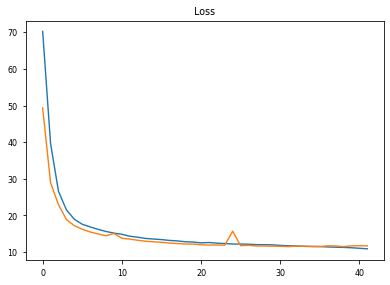

In [114]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [115]:
# результаты на валидации хуже, чем у предыдущих моделей
predict_nn3 = model.predict(test_dataset.batch(16))
print(f"TEST mape: {(mape(np.exp(y_test), predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.45%


In [116]:
sub_predict_nn3 = model.predict(sub_dataset.batch(16))
sample_submission['price'] = sub_predict_nn3[:, 0]
sample_submission['price'] = round_to(sample_submission['price'], 1000)
sample_submission.to_csv('nn3_submission_round.csv', index=False)

In [117]:
# усредненные предикты нейросетей показывают лучший результат на валидации, чем простая полносвязная сеть
avg_predict_nn = (predict_tabular_nn[:,0] + predict_nn2[:,0] + predict_nn3[:,0])/3
print(f"TEST mape: {(mape(np.exp(y_test), avg_predict_nn))*100:0.2f}%")

TEST mape: 10.85%


In [118]:
avg_predict_nn_sub = (predict_sub_tabular_nn[:,0] + sub_predict_nn2[:,0] + sub_predict_nn3[:,0])/3

In [119]:
# усредненные предикты нейросесей и моделей ML
# на валидации результат сопоставим с усреднением предиктов ML  и простой нейросети
total_avg_pred = (np.exp(avg_predict_ml) + avg_predict_nn)/2
print(f"TEST mape: {(mape(np.exp(y_test), new_pred))*100:0.2f}%")

TEST mape: 10.27%


In [120]:
# на тестовой выборке усредненные предсказания нейросесей и моделей ML показывают самый лучший результат!
sample_submission['price'] = (predict_avg_ml_submission + avg_predict_nn_sub)/2
sample_submission['price'] = round_to(sample_submission['price'], 1000)
sample_submission.to_csv('total_avg_ml_nn_submission_round.csv', index=False)
sample_submission.head()


# Kaggle 10.96681

,sell_id,price
0,1099427284,668000.0
1,1096405886,2518000.0
2,1100195294,642000.0
3,1099827282,485000.0
4,1100076198,2686000.0


Для улучшения метрики увеличили размер тренировочной выборки до 0.95 (хотя это делает валидацию модели менее надежной)
#### Итоговый результат на Kaggle - 10.89261

## Общие выводы:

Асамблирование моделей ML и моделей глубокого обучения (нейросетей) показало наилучший результат на тестовой выборке. При сопоставимом уровне ошибки они, видимо, извлекают разные признаки из данных. Примечательный результат, если учитывать небольшое количество данных в тренировочной выборке.  


### Что можно еще сделать, чтобы улучшить результат:
* собрать дополнительные данные (для нейросетей нужно много данных!)
* добавить больше дополнительных признаков (feature engineering)
* дополнительно поэкспериментировать с архитектурами и параметрами используемых моделей, а также темпом обучения

#### Что еще было сделано, но не попало в финальный ноутбук (не было закончено)
* подбор параметров с помощью библиотеки optuna
* использование для анализа текста трансформеров вместо рекуррентных сетей (см дополнительный ноутбук)

In [ ]:
#from sklearn.metrics import mean_squared_error
#import math

#def objective(trial):
#    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.15)

#    param = {
        #"loss_function": trial.suggest_categorical("loss_function", ["mean_squared_error"]),
#        "eval_metric": trial.suggest_categorical("eval_metric", ['MAPE', 'MAE']),
#        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
#        "depth": trial.suggest_int("depth", 1, 12),
#        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#        "bootstrap_type": trial.suggest_categorical(
#            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
#       ),
#        "used_ram_limit": "3gb",
#    }

#    if param["bootstrap_type"] == "Bayesian":
#        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
#    elif param["bootstrap_type"] == "Bernoulli":
#        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

#    gbm = cb.CatBoostRegressor(**param, iterations = 10000)

#    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

#    preds = gbm.predict(valid_x)
#    pred_labels = np.rint(preds)
#    accuracy = mean_squared_error(valid_y, pred_labels)
#    return accuracy

#study = optuna.create_study(direction="minimize")
#study.optimize(objective, n_trials=5, timeout=600, show_progress_bar = True)

#print("Number of finished trials: {}".format(len(study.trials)))

#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))

#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))